In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
# import gensim
import logging
import pprint
import os
import re

import warnings
warnings.filterwarnings("ignore")

from music21 import converter, corpus, instrument, midi, note, chord, pitch, roman, stream
import mido
from mido import Message, MidiFile, MidiTrack
# from sklearn.metrics import jaccard_score

# from miditok import REMI, get_midi_programs
# from miditoolkit import MidiFile

Min criteria: (minimally adequate) min 0.5/1 sec long min 4/5 keydowns

Max criteria: (multiple for better match) 100 keydowns 10 seconds

-> single length search -> multiple length search

-> maybe if multiple matches, check longer length

-> find a linear transfformation and how well it matches, penalize for extra notes

For 10 Jan 2023 -> find minimally adequate match and see accuracy/ how often we find a match

### 1. Convert note events to timeseries
eg [[0,'C3'],[2,'D3'],[35,'D#3'],[102,'C3']]


In [59]:
# returning all note on events from file in the form [[t,note,vel],[t,note,vel],[t,note,vel],...]
def midi_to_timeseries(midiPath):
    
    time_notes = []
#     midiFile = converter.parse(midiPath)
    uniqueTypes = [128,144,176]
    with open(midiPath) as midi_events:
        for line in midi_events:
            processedLine = line.split(" ")
    
            processedLine[0] = int(processedLine[0])
            processedLine[1] = int(processedLine[1], 16)

            if processedLine[1] not in uniqueTypes:
                print("unexpected event type got! ", processedLine[1])

            #    MIDI EVENT TYPES
            #    0x80 (hex)      128 (decimal)    Note Off
            #    0x90 (hex)      144 (decimal)    Note On
            #    0xB0 (hex)      176 (decimal)    Continuous Controller

            # processedLine[2] is note
            processedLine[2] = str(int(processedLine[2], 16))

            # processedLine[3] is velocity
            processedLine[3] = str(int(processedLine[3],16))

            if processedLine[1] == 144:
                time_notes.append([processedLine[0], processedLine[2], processedLine[3]])
                
    return time_notes



In [60]:
# generate dataframe of snippets
midiPath = '/Users/snehashah/Desktop/Stagecast/midi-recordings/ladispute.txt'
time_notes = midi_to_timeseries(midiPath)
#plot time_notes?

### STEP 2: Define a simplest similarity metric 

Asumptions & notes: 

-> no mistakes

-> multiple notes can be played together (so don't look at order)

-> done wrt time not note events (timeseries)

-> ignoring vel

-> discriminate between octaves

-> traversing note by note (not ms by ms)

-> no time limit (0.5ms)

In [89]:
def musical_similarity(tf1, tf2):
    sequence1 = []
    first = tf1[0]
    for el in tf1:
        sequence1.append([el[0]-first[0],el[1]])
        
    sequence2 = []
    first = tf2[0]
    for el in tf2:
        sequence2.append([el[0]-first[0],el[1]])
        
    score = []
    for event1 in range(len(sequence1)):
        for event2 in range(len(sequence2)):
            s = note_similarity(sequence1[event1],sequence2[event2])
#             print(sequence1[event1],sequence2[event2])
            if s != 0:
                score.append(s)
                sequence1[event1] = []
                sequence2[event2] = []
                break
                
    for i in range(len(sequence1) + len(sequence2) - (2*len(score))):
        score.append(0)
        
#     print(sequence1)
#     print(sequence2)
#     print(score)
    return np.mean(score)
        
        
def note_similarity(note1,note2):
    # score is linear with time difference between notes
    
#     strictness = 0.2 # note within 10% time difference
    min_dist = 100 # 300ms is arbitrary audible difference
    
    if (not note1) or (not note2):
        return 0
    if note1 == note2: # exact match!
        return 1
    if note1[1] != note2[1]: # different notes
        return 0
    
    # check if acceptable match
    time_diff = abs(note1[0] - note2[0])
#     print(time_diff)
    if  time_diff < min_dist:
        return 1 - time_diff/500
    else:
        return 0
    
def get_note(i):
    # convert integer to note
    notes = ['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B']
    return notes[i%12] + str(i//12 - 1)

def get_int(note):
    # convert integer to note
    temp = re.compile("([a-zA-Z]+)([0-9]+)")
    note = temp.match(note).groups()
    notes = {'C':0,'C#/Db':1,'C#':1,'Db':1,'D':2,'D#/Eb':3,'D#':3,'Eb':3,'E':4,'F':5,'F#/Gb':6,'F#':6,'Gb':6,'G':7,'G#/Ab':8,'Ab':8,'G#':8,'A':9,'A#/Bb':10,'A#':10,'Bb':10,'B':11}
    return notes[note[0]] + 12*(int(note[1])+1)


def calculate_similarity(source, targets):
    matches = []
    count = 0
    for target in targets:
        score = musical_similarity(source, target)
        if score:
            matches.append([count, score, source[0], target[0]])
        count += 1
        
    return matches


In [75]:
# Zulip example
tf1 = [[-17,60],[-100,62],[-101,64],[-300,60]]
tf2 = [[-20,60],[-50,61],[-101,64],[-102,62],[-307,60]]

musical_similarity(tf1,tf2)

0.7968

In [87]:
# Snippet note length = 1
minNotes = 4
maxNotes = 8
history = 'full'

# generate dataframe of snippets
snips = []
midiPath = '/Users/snehashah/Desktop/Stagecast/midi-recordings/ladispute.txt'
notes = midi_to_timeseries(midiPath)

for j in range(minNotes, maxNotes+1):
    ind = j - minNotes
    snips.append([])
    for i in range(len(notes)+1-j):
        snip = notes[i: i+j]
        snips[ind].append(snip)

notes

[[251, '51', '48'],
 [254, '63', '45'],
 [837, '55', '51'],
 [842, '58', '48'],
 [1495, '58', '37'],
 [1500, '55', '47'],
 [2068, '70', '56'],
 [2072, '51', '48'],
 [2637, '55', '45'],
 [2649, '58', '42'],
 [3272, '55', '41'],
 [3299, '58', '27'],
 [3738, '63', '39'],
 [3810, '50', '49'],
 [3832, '62', '61'],
 [4414, '59', '45'],
 [4446, '55', '49'],
 [5035, '55', '45'],
 [5059, '59', '39'],
 [5665, '71', '55'],
 [5676, '50', '45'],
 [6271, '55', '51'],
 [6276, '59', '34'],
 [6819, '55', '48'],
 [6835, '59', '29'],
 [7045, '62', '49'],
 [7121, '63', '54'],
 [7205, '65', '59'],
 [7388, '63', '54'],
 [7405, '51', '53'],
 [8027, '58', '36'],
 [8029, '55', '44'],
 [8585, '55', '49'],
 [8599, '58', '44'],
 [9236, '70', '58'],
 [9247, '51', '46'],
 [9846, '55', '45'],
 [9849, '58', '32'],
 [10453, '55', '48'],
 [10465, '58', '39'],
 [10899, '63', '52'],
 [11035, '50', '42'],
 [11047, '62', '56'],
 [11629, '59', '46'],
 [11631, '55', '46'],
 [12224, '59', '42'],
 [12230, '55', '48'],
 [12839,

In [82]:
# new similarity

sims = np.zeros((len(notes),len(notes)))
for i in range(len(notes)):
    print("\r",end="")
    print("i:",i,end=", j:       ")
    for j in range(minNotes, maxNotes+1): # j is length of notes
        if i-j<0:
            break
#         print("\b",end="")
#         print("\b",end="")
#         print(j,end="")
        ind = j - minNotes
        # only calculate on historical timestamps
        source = snips[ind][i-j]
        targets = snips[ind][0:i+1-j]
        sim = calculate_similarity(source, targets)
        # create a single df
        for match in sim:
            # add source measure location
            match.insert(0, i)
            match[1] += j
            ''' Fix this: Source timestamp, Target timestamp, Score'''
            sims[match[0]][match[1]] += match[2]
#             if match[0] in sims:
#                 sims[match[0]] += match[1]
#             else:
#                 sims[match[0]] = match[1]
#             sims.append(match)
            '''Till here'''
sims_arr = []
for row in range(len(sims)):
    for col in range(len(sims[0])):
        if sims[row][col] != 0:
            sims_arr.append([row,col,sims[row][col]])


i: 2991, j:       

<AxesSubplot:title={'center':'MIDI Note Vectorization, Snippet Length=4, Similarity=musical_similarity'}, xlabel='source_timestamp', ylabel='target_timestamp'>

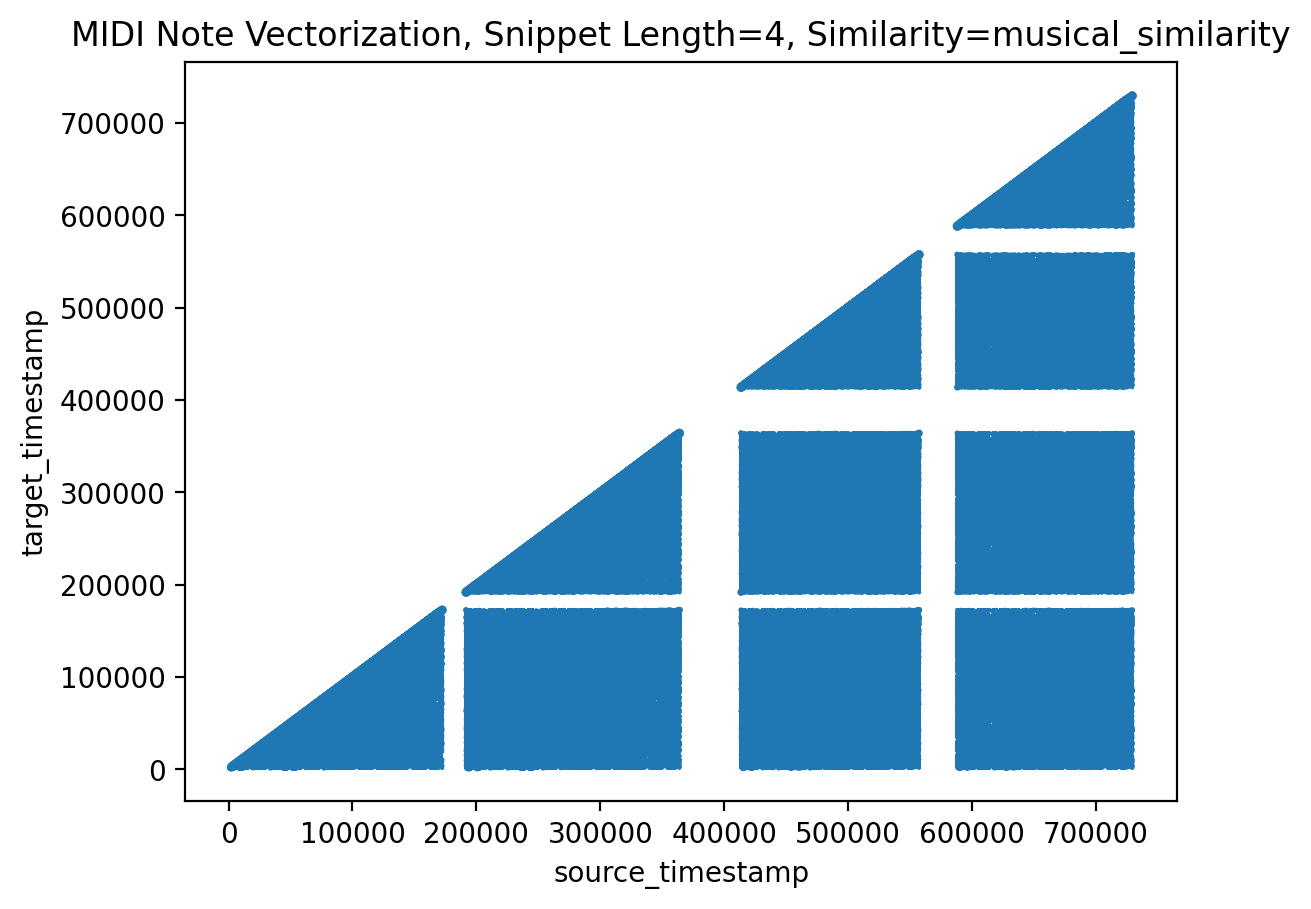

In [88]:
simsDF = pd.DataFrame(data=sims_arr, columns=['source_timestamp', 'target_timestamp', 'score'])
simsTimeDF = pd.DataFrame(data=simsTimeArr, columns=["source_noteIDX", "target_noteIDX", "score", "source_timestamp", "target_timestamp"])

title = "MIDI Note Vectorization, Snippet Length=" + str(minNotes) + ", Similarity=musical_similarity" 
simsTimeDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)


<AxesSubplot:title={'center':'MIDI Note Vectorization, Snippet Length=4, Similarity=musical_similarity'}, xlabel='source_timestamp', ylabel='target_timestamp'>

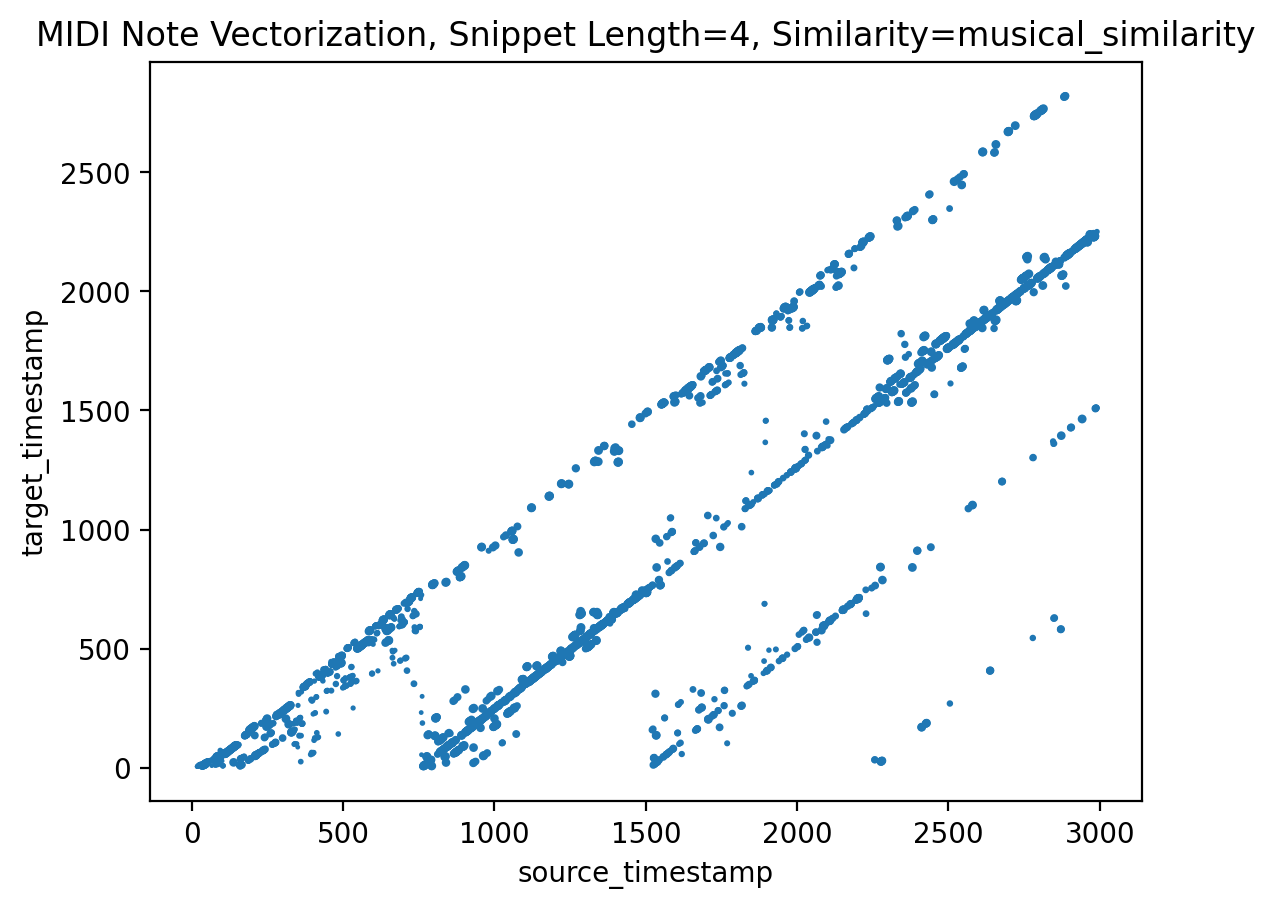

In [84]:
'''Maximum plot for above'''
sims_max = []
for row in range(11,len(sims)):
    maxi = np.argmax(sims[row][0:row-10])
    sims_max.append([row,maxi,sims[row][maxi]])
simsDF = pd.DataFrame(data=sims_max, columns=['source_timestamp', 'target_timestamp', 'score'])
title = "MIDI Note Vectorization, Snippet Length=" + str(minNotes) + ", Similarity=musical_similarity"
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)